In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import itertools
import torch
import numpy as np
import abstract_gradient_training as agt
sys.path.append("..")
from models.fully_connected import FullyConnected
from datasets.uci import get_dataloaders

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [107]:
# configure the training parameters
batchsize = 10000
nominal_config = agt.AGTConfig(
    fragsize=10000,
    learning_rate=0.02,
    lr_decay=0.5,
    lr_min=0.001,
    epsilon=0.02,
    k_poison=2000,
    # clip_gamma=0.01,
    n_epochs=1,
    device="cuda:1",
    forward_bound="interval",
    backward_bound="interval",
    loss="mse",
    log_level="INFO",
    early_stopping=False,
    metadata=f"uci, batchsize={batchsize}",
    bound_kwargs={"interval_matmul": "exact"}
)

In [40]:
# get the data and nn model
torch.manual_seed(0)
dl_train, dl_test = get_dataloaders(batchsize, batchsize, "houseelectric", n_batches=30)
test_batch, test_label = next(iter(dl_test))
dl_test = itertools.cycle([(test_batch, test_label)])
# dl_test = itertools.cycle([next(iter(dl_test))])
model = FullyConnected(11, 1, 50, 1)  # network with 1 hidden layer of 64 neurons

houseelectric dataset, N=2049280, d=11


In [110]:
conf = copy.deepcopy(nominal_config)
conf.k_private = conf.k_poison
agt_training = []
def log(*args):
    agt_training.append(copy.deepcopy(args))
conf.callback = log

# train the model
param_l, param_n, param_u = agt.poison_certified_training(model, conf, dl_train, dl_test)

# evaluate the trained model
mse = agt.test_metrics.test_mse(param_l, param_n, param_u, *next(iter(dl_test)))
print(f"Test MSE: nominal = {mse[1]:.4g}, certified upper bound = {mse[0]:.4g}, certified lower bound = {mse[2]:.4g}")

[AGT] [INFO    ] [17:35:28] =================== Starting Poison Certified Training ===================
[AGT] [INFO    ] [17:35:28] Starting epoch 1
[AGT] [INFO    ] [17:35:29] Training batch 1: Network eval bounds=(0.17, 0.17, 0.17), W0 Bound=0.0 
[AGT] [INFO    ] [17:35:29] Training batch 2: Network eval bounds=(0.14, 0.14, 0.14), W0 Bound=0.00222 
[AGT] [INFO    ] [17:35:29] Training batch 3: Network eval bounds=(0.13, 0.12, 0.12), W0 Bound=0.00368 
[AGT] [INFO    ] [17:35:29] Training batch 4: Network eval bounds=(0.12, 0.11, 0.11), W0 Bound=0.0048 
[AGT] [INFO    ] [17:35:29] Training batch 5: Network eval bounds=(0.11, 0.1 , 0.1 ), W0 Bound=0.00571 
[AGT] [INFO    ] [17:35:29] Training batch 6: Network eval bounds=(0.11, 0.099, 0.093), W0 Bound=0.00648 
[AGT] [INFO    ] [17:35:29] Training batch 7: Network eval bounds=(0.1 , 0.095, 0.088), W0 Bound=0.00716 
[AGT] [INFO    ] [17:35:30] Training batch 8: Network eval bounds=(0.098, 0.091, 0.084), W0 Bound=0.00776 
[AGT] [INFO    ] [

Test MSE: nominal = 0.06473, certified upper bound = 0.0776, certified lower bound = 0.05322


In [111]:
train_model = copy.deepcopy(model)

train_params, _, _ = agt.training_utils.get_parameters(train_model)
criterion = torch.nn.MSELoss()

standard_training = []
test_iterator = itertools.cycle(dl_test)
lrk = 0
with torch.no_grad():
    for _ in range(nominal_config.n_epochs):
        for x, y in dl_train:
            lr = max(nominal_config.learning_rate / (1 + nominal_config.lr_decay * lrk), nominal_config.lr_min)
            lrk += 1
            test_batch, test_labels = next(test_iterator)
            test_batch, test_labels = test_batch.to(nominal_config.device), test_labels.to(nominal_config.device)
            *_, y_test = agt.nominal_pass.nominal_forward_pass(test_batch, train_params)
            standard_training.append(criterion(y_test, test_labels).item())
            if x.size(0) != batchsize:
                continue
            # print(f"Test MSE: {standard_training[-1]:.4g}")
            x, y = x.to(nominal_config.device), y.to(nominal_config.device)

            activations_n = agt.nominal_pass.nominal_forward_pass(x, train_params)
            _, _, dl_n = nominal_config.loss_bound_fn(activations_n[-1], activations_n[-1], activations_n[-1], y)
            grads_n = agt.nominal_pass.nominal_backward_pass(dl_n, param_n, activations_n)
            grads_n = [g.clamp(-nominal_config.clip_gamma, nominal_config.clip_gamma) for g in grads_n]
            grads_n = [g.mean(dim=0) for g in grads_n]
            for p, g in zip(train_params, grads_n):
                p -= lr * g

In [112]:
print(standard_training)
print([x[0][1] for x in agt_training])

[0.17373639345169067, 0.14026157557964325, 0.12326455861330032, 0.11244113743305206, 0.10483327507972717, 0.09918802231550217, 0.09467773139476776, 0.09098691493272781, 0.08793588727712631, 0.08534172177314758, 0.08313613384962082, 0.08117838203907013, 0.07946502417325974, 0.07793248444795609, 0.07654336839914322, 0.07526269555091858, 0.07414544373750687, 0.07308421283960342, 0.07213708013296127, 0.07124432176351547, 0.07043987512588501, 0.06968066841363907, 0.06896055489778519, 0.06829801946878433, 0.06765563786029816, 0.06705790758132935, 0.06647713482379913, 0.06595306098461151, 0.0654420480132103, 0.06496487557888031]
[0.17373639345169067, 0.14027203619480133, 0.1233343631029129, 0.11255644261837006, 0.10498087853193283, 0.09935830533504486, 0.09486495703458786, 0.09118673205375671, 0.08814515173435211, 0.08555806428194046, 0.08335766196250916, 0.08140399307012558, 0.07969368249177933, 0.07816339284181595, 0.07677595317363739, 0.075496606528759, 0.07438008487224579, 0.0733193829655

In [113]:
def craft_poison(params, examples, labels, objective, epsilon, max_iter=100):
    x0 = examples.clone().detach()
    x0.requires_grad = True
    for _ in range(max_iter):
        optimizer = torch.optim.Adam([x0], lr=0.1)
        activations_n = agt.nominal_pass.nominal_forward_pass(x0, params)
        _, _, dL = nominal_config.loss_bound_fn(activations_n[-1], activations_n[-1], activations_n[-1], labels)
        grads = agt.nominal_pass.nominal_backward_pass(dL, param_n, activations_n)
        obj = objective(grads)
        # obj = grads[layer].flatten()[param_idx_1] + grads[layer].flatten()[param_idx_2]
        optimizer.zero_grad()
        obj.backward()
        optimizer.step()
        # project back to epsilon ball
        x0.data = x0.clamp(examples - epsilon, examples + epsilon)
    return x0

In [114]:
def train_poison(model, config, poison_objective):
    poison_model = copy.deepcopy(model)

    poison_params, _, _ = agt.training_utils.get_parameters(poison_model)
    poison_param_list = []
    criterion = torch.nn.MSELoss()
    
    poison_training = []
    test_iterator = itertools.cycle(dl_test)
    lrk = 0
    for _ in range(config.n_epochs):
        for x, y in dl_train:
            poison_param_list.append([p.clone().detach() for p in poison_params])
            lr = max(config.learning_rate / (1 + config.lr_decay * lrk), config.lr_min)
            lrk += 1
            test_batch, test_labels = next(test_iterator)
            test_batch, test_labels = test_batch.to(config.device), test_labels.to(config.device)
            *_, y_test = agt.nominal_pass.nominal_forward_pass(test_batch, poison_params)
            poison_training.append(criterion(y_test, test_labels).item())
            if x.size(0) != batchsize:
                continue
            # print(f"Test MSE: {standard_training[-1]:.4g}")
            x, y = x.to(config.device), y.to(config.device)
            # poison config.k_poison examples
            selected = torch.randperm(x.size(0))[: config.k_poison]
            poison_x = craft_poison(
                poison_params, x[selected], y[selected], poison_objective, config.epsilon
            )
            # replace the examples with the poisoned examples
            with torch.no_grad():
                x[selected] = poison_x
                activations_n = agt.nominal_pass.nominal_forward_pass(x, poison_params)
                _, _, dl_n = config.loss_bound_fn(activations_n[-1], activations_n[-1], activations_n[-1], y)
                grads_n = agt.nominal_pass.nominal_backward_pass(dl_n, param_n, activations_n)
                grads_n = [g.clamp(-config.clip_gamma, config.clip_gamma) for g in grads_n]
                grads_n = [g.mean(dim=0) for g in grads_n]
                for p, g in zip(poison_params, grads_n):
                    p -= lr * g
    return poison_training, poison_param_list

In [123]:
from collections import defaultdict

poison_trajectories = defaultdict(list)

In [122]:
def get_poison_trajectories(model, config, layer, idx_1, idx_2):
    
    objectives = [
        lambda grads: grads[layer].sum(dim=0).flatten()[idx_1],
        lambda grads: grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: grads[layer].sum(dim=0).flatten()[idx_1] + grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: grads[layer].sum(dim=0).flatten()[idx_1] - grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: - grads[layer].sum(dim=0).flatten()[idx_1] - grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: - grads[layer].sum(dim=0).flatten()[idx_1] + grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: - grads[layer].sum(dim=0).flatten()[idx_1] * grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: grads[layer].sum(dim=0).flatten()[idx_1] * grads[layer].sum(dim=0).flatten()[idx_2],
        lambda grads: - grads[layer].sum(dim=0).flatten()[idx_1],
        lambda grads: - grads[layer].sum(dim=0).flatten()[idx_2],
    ]
    
    poison_trajectories = []
    for objective in objectives:
        _, poison_param_list = train_poison(model, config, objective)
        poison_trajectories.append(poison_param_list)
    return poison_trajectories

In [186]:
def plot_params(training, layer, i, j, step=5, traj=None, ax=None, conf=False):
    p_l = [p.flatten().cpu().numpy() for p in list(zip(*[t[1] for t in training]))[layer]]
    p_n = [p.flatten().cpu().numpy() for p in list(zip(*[t[2] for t in training]))[layer]]
    p_u = [p.flatten().cpu().numpy() for p in list(zip(*[t[3] for t in training]))[layer]]
    L = len(p_l)
    palette = sns.color_palette("rocket", n_colors=L // step + 1)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for k in range(0, L, step):
        x_l = p_l[k][i]
        x_u = p_u[k][i]
        y_l = p_l[k][j]
        y_u = p_u[k][j]
        box = mpl.patches.Rectangle(
            (x_l, y_l), x_u - x_l, y_u - y_l, edgecolor=palette[k // step], alpha=0.5, facecolor="none"
        )
        ax.add_patch(box)

    if traj:
        palette = iter(sns.color_palette("deep", n_colors=len(traj)))
        for t in traj:
            ax.plot(
                [p[layer].flatten()[i].cpu().detach().numpy() for p in t],
                [p[layer].flatten()[j].cpu().detach().numpy() for p in t],
                color="grey",
                linestyle="--",
                # alpha=0.5,
                # marker="x",
                # markersize=3,
            )
    ax.plot(
        [p_n[k][i] for k in range(L)],
        [p_n[k][j] for k in range(L)],
        color="red",
        # marker="x",
        # alpha=0.5,
        # markersize=3,
    )
    ax.set_box_aspect(1)
    # plt.axis("scaled")
    if conf:
        config_text = '\n'.join([str(s) for s in dict(nominal_config).items()])
        plt.text(
            1.05,
            0.01,
            config_text,
            # f"{nominal_config.k_poison} poisoned,\n{nominal_config.epsilon} epsilon,\n{nominal_config.clip_gamma} clipping",
            verticalalignment="bottom",
            horizontalalignment="left",
            transform=ax.transAxes,
            color="green",
            fontsize=9,
        )
    # ax.set_ylim(min([p_l[k][j] for k in range(L)]), max([p_u[k][j] for k in range(L)]))
    # ax.set_xlim(min([p_l[k][i] for k in range(L)]), max([p_u[k][i] for k in range(L)]))

In [174]:
poison_layer = 2
selected = [
    (12, 36),
    (13, 24),
    # (40, 37),
    (0, 4),
    (33, 17),
]

for s in selected:
    if s not in poison_trajectories:
        if (s[-1], s[-2]) in poison_trajectories:
            poison_trajectories[s] = poison_trajectories[(s[-1], s[-2])]
        else:
            poison_trajectories[s].extend(get_poison_trajectories(model, nominal_config, poison_layer, *s))

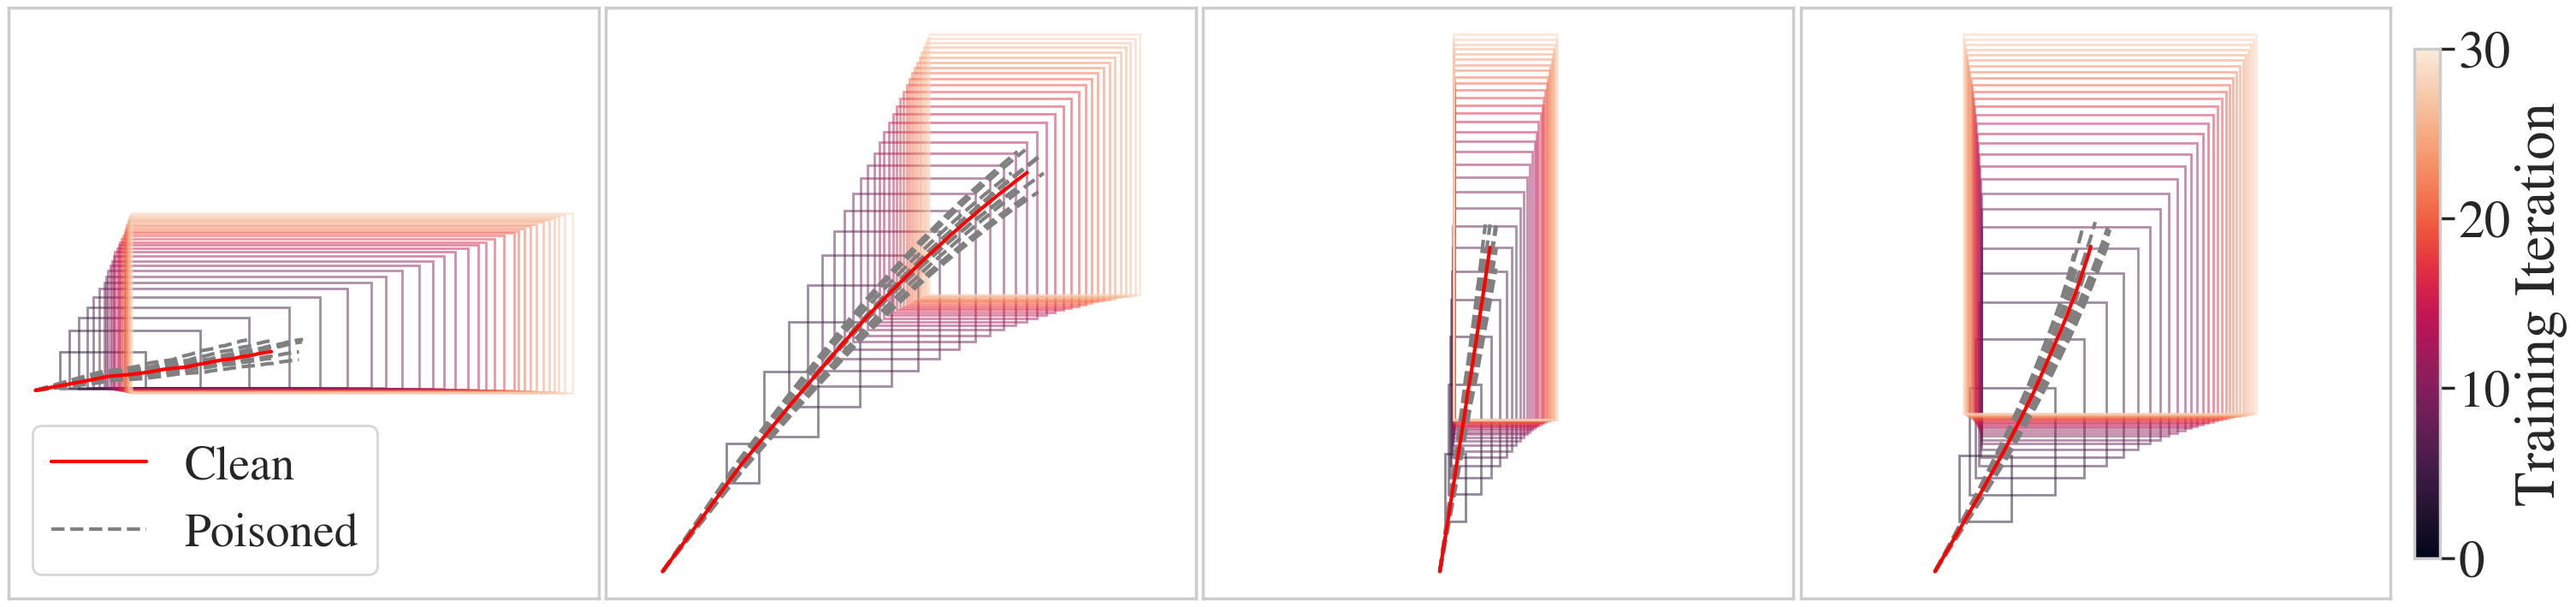

In [194]:
palette = sns.color_palette(palette="Dark2", n_colors=12)
lb_color = list(iter(sns.color_palette(palette="deep")))[-1]
ub_color = list(iter(sns.color_palette(palette="deep")))[-2]

sns.set_theme(context="poster", style="whitegrid", font_scale=2.0)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
labelsize = 22

fig, ax = plt.subplots(1, 4, figsize=(30, 10), layout="constrained", gridspec_kw={"width_ratios": [1, 1, 1, 1], "wspace": 0.01 , "hspace": 0.01})

for (i, j), a in zip(selected, ax):
    a.axes.set_aspect("equal")
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    title = r"$\theta_{" + str(i) + r"}$ vs $\theta_{" + str(j) + "}$"
    # a.set_title(title)
    plot_params(agt_training, poison_layer, i, j, step=1, traj=poison_trajectories[(i, j)], ax=a)
norm = mpl.colors.Normalize(vmin=0, vmax=len(agt_training))
sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.02, pad=0.01, shrink=0.6, label="Training Iteration")


ax[0].plot([], [], color="red", label="Clean")
ax[0].plot([], [], color="grey", label="Poisoned", linestyle="--")
ax[0].legend(loc="lower left", fontsize=40)

plt.savefig(".figures/param_space_poison.pdf", bbox_inches="tight", dpi=300)

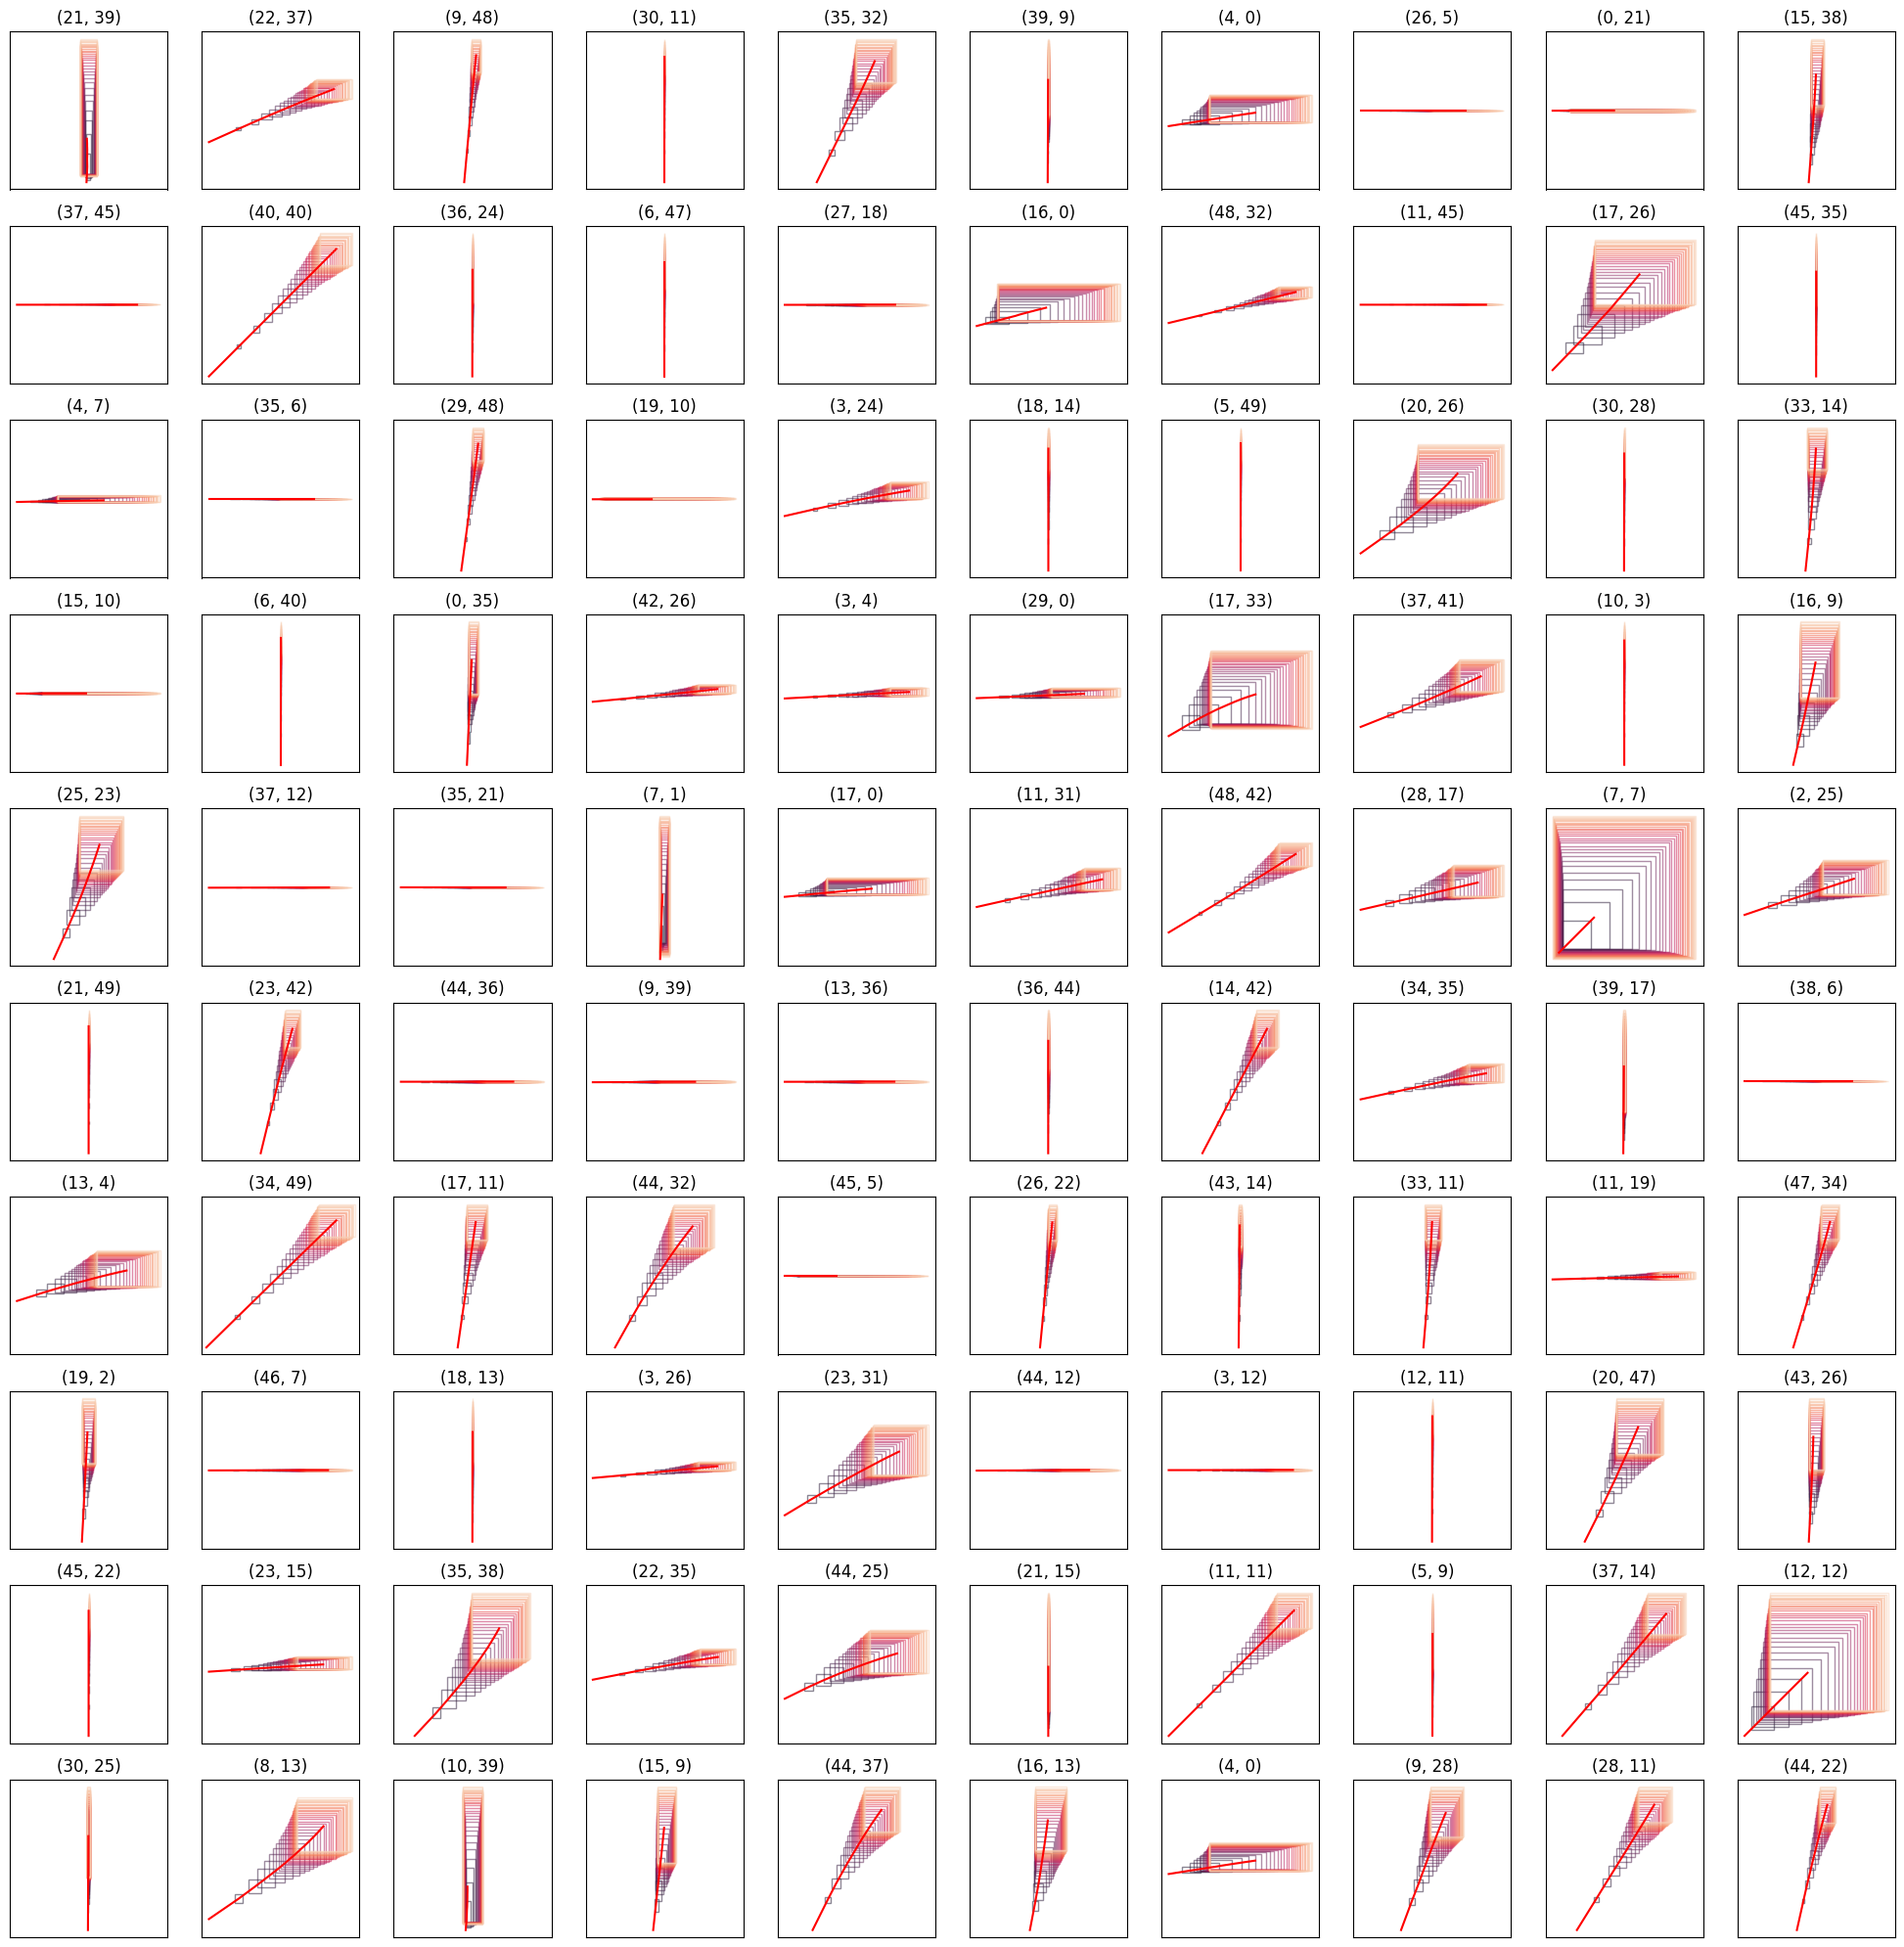

In [145]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20), layout="tight")

for a in ax.flatten():
    a.axes.set_aspect("equal")
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    i = np.random.randint(0, 50)
    j = np.random.randint(0, 50)
    
    # title = r"$\theta_{" + str(i) + r"}$ vs $\theta_{" + str(j) + "}$"
    a.set_title((i, j))
    plot_params(agt_training, poison_layer, i, j, step=1, ax=a)

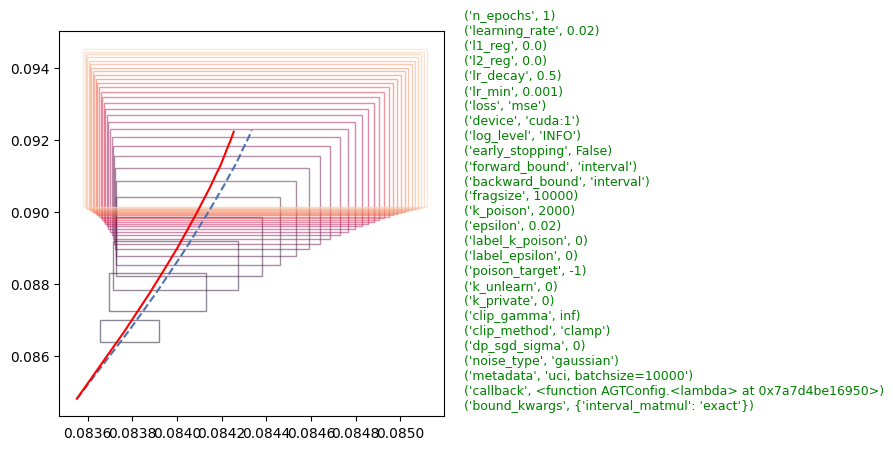

In [121]:
poison_layer = 2
poison_idx_1 = 1
poison_idx_2 = 2

p_traj = []
objective = lambda grads: grads[poison_layer].sum(dim=0).flatten()[poison_idx_1]
_, poison_param_list = train_poison(model, nominal_config, objective)
p_traj.append(poison_param_list)

plot_params(agt_training, poison_layer, poison_idx_1, poison_idx_2, step=1, traj=p_traj, conf=True)



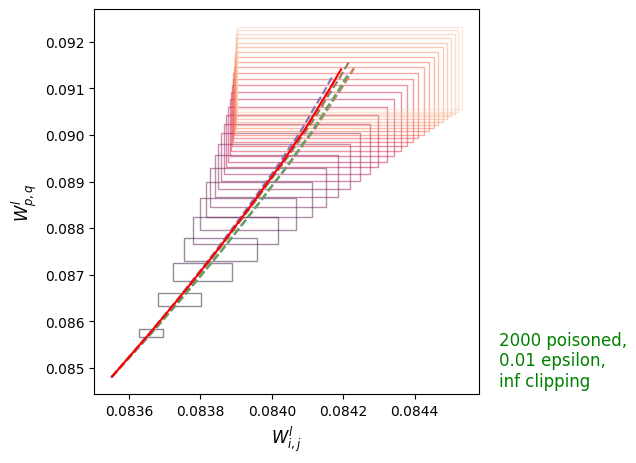

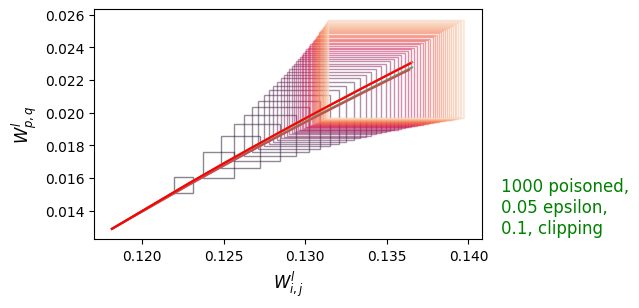

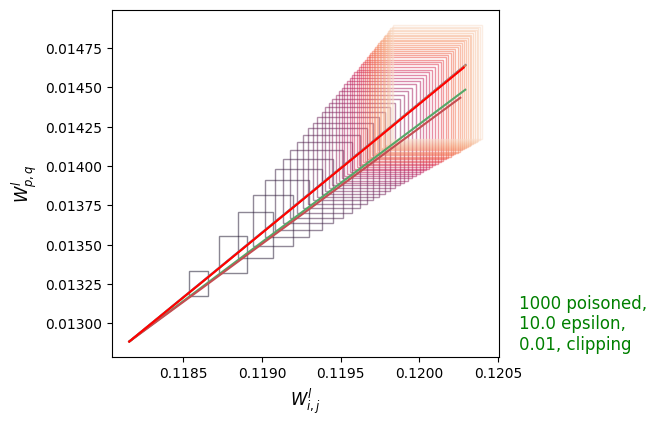

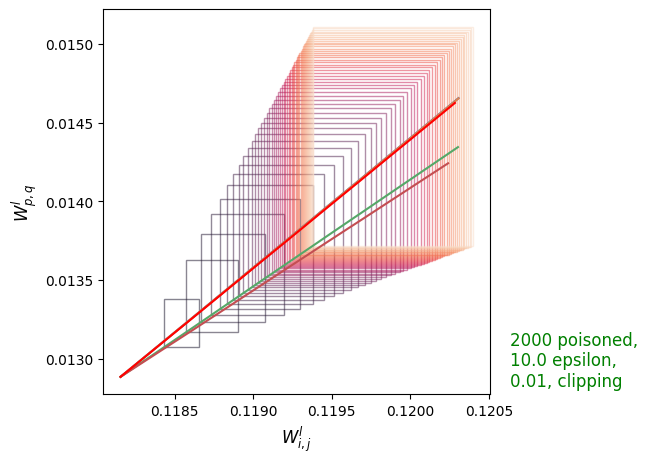

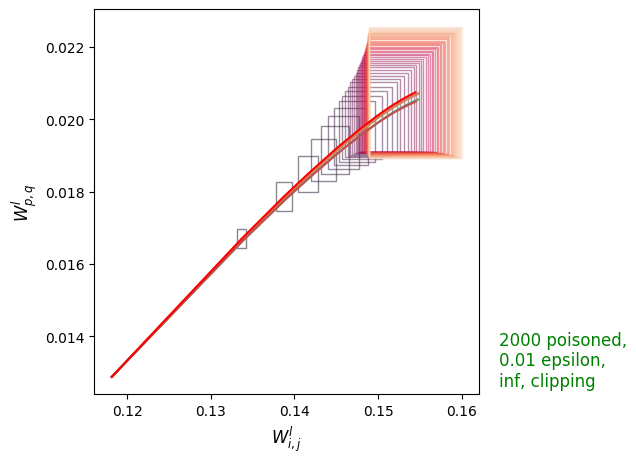

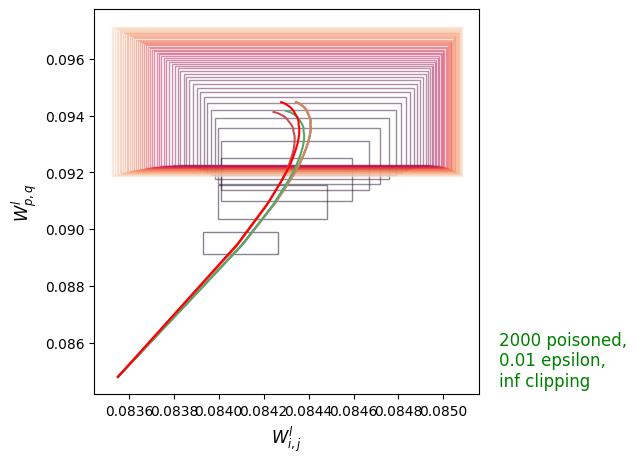